In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import time

from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.manifold import TSNE
from tensorboard.backend.event_processing import event_accumulator
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Read CSV

In [3]:
data = pd.read_csv('data.csv')
data.head(5)

,image_path,label
0,images\anime_image_1.jpg,1
1,images\anime_image_10.jpg,1
2,images\anime_image_100.jpg,1
3,images\anime_image_101.jpg,1
4,images\anime_image_102.jpg,1


In [4]:
data.tail(5)

,image_path,label
1295,images\technology_image_95.jpg,0
1296,images\technology_image_96.jpg,0
1297,images\technology_image_97.jpg,0
1298,images\technology_image_98.jpg,0
1299,images\technology_image_99.jpg,0


#### Let's preview some images

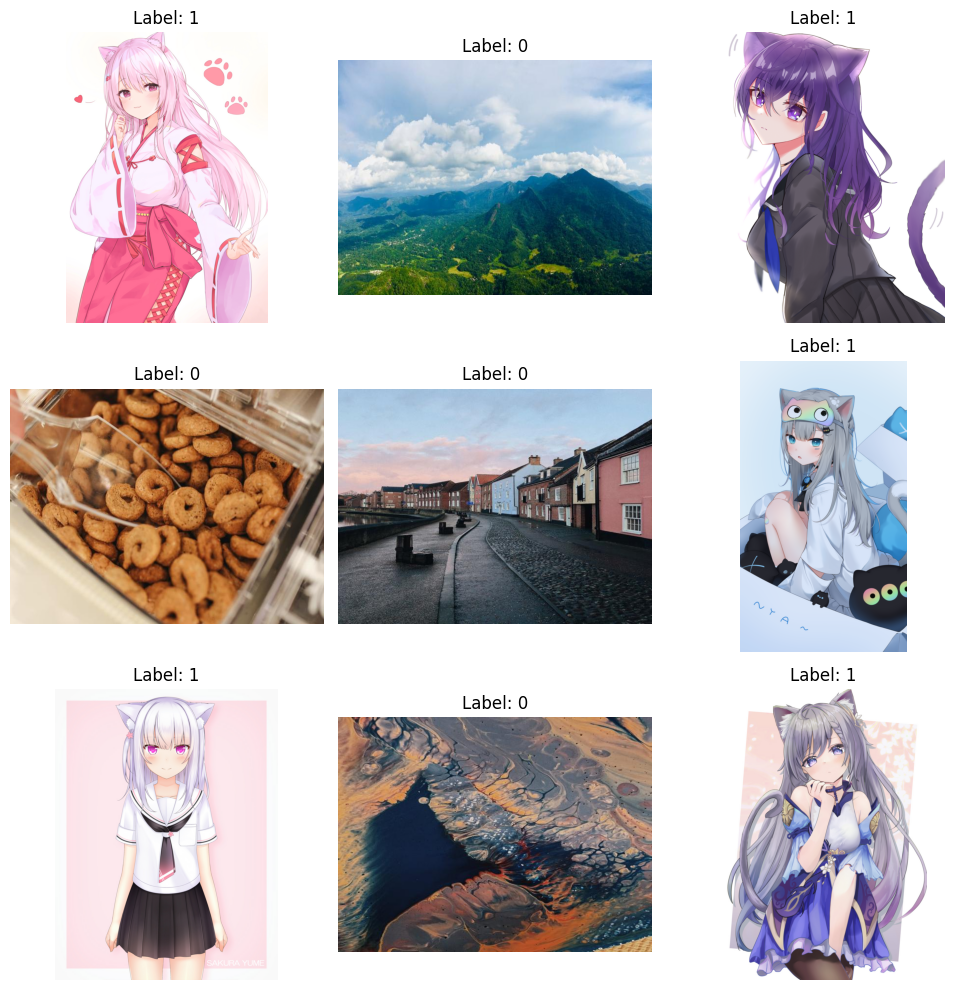

In [5]:
random_indices = random.sample(range(len(data)), 9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    img_path = data.iloc[idx, 0]
    label = data.iloc[idx, 1]
    image = Image.open(img_path).convert('RGB')

    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

##

#### Make train and test datasets

In [6]:
class AnimeDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [8]:
train_dataset = AnimeDataset(csv_file='data.csv', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

###

#### CNN

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv5(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv6(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv7(x))
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [27]:
model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
writer = SummaryWriter()

In [29]:
start_time = time.time()

In [30]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    writer.add_scalar('Loss/train', running_loss / len(train_loader), epoch)
    print(f'Epoch: {epoch+1}')
    print(f'Loss: {running_loss/len(train_loader)}')

Epoch: 1
Loss: 0.9001351107911366
Epoch: 2
Loss: 0.4166643708580878
Epoch: 3
Loss: 0.3457253873348236
Epoch: 4
Loss: 0.28434835374355316
Epoch: 5
Loss: 0.20808919128484843


In [31]:
end_time = time.time()
print(f'CNN train time: {end_time - start_time} seconds')

CNN train time: 803.1214926242828 seconds


In [32]:
writer.close()

###

#### Embedding creation + visualisation

In [33]:
model.eval()
embeddings = []
labels_list = []

In [34]:
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        features = model.conv2(model.conv1(images))
        features = nn.functional.max_pool2d(features, 2)
        features = features.view(features.size(0), -1)
        embeddings.append(features.cpu().numpy())
        labels_list.append(labels.numpy())

In [35]:
embeddings = np.vstack(embeddings)
labels_list = np.hstack(labels_list)

In [36]:
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings)

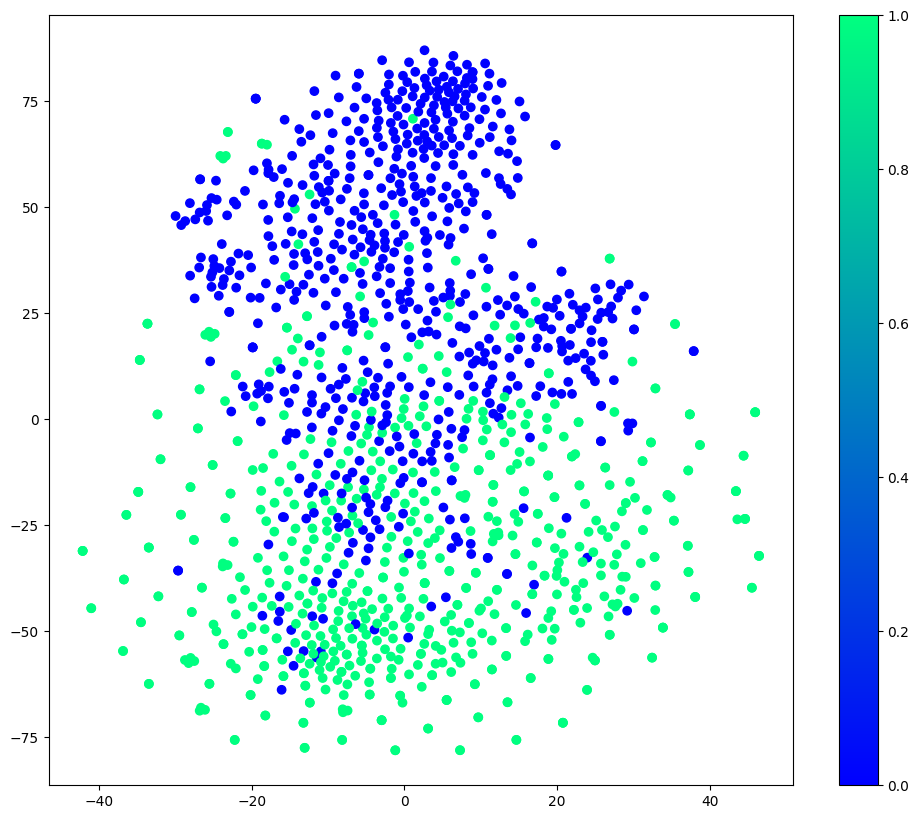

In [37]:
plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_list, cmap='winter')
plt.colorbar()
plt.show()

##

#### Transfer learning model

In [38]:
class TransferLearning(nn.Module):
    def __init__(self):
        super(TransferLearning, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = torch.sigmoid(x)
        return x

In [39]:
model_transfer = TransferLearning().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_transfer.parameters(), lr=0.001)

C:\Users\pzns1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pzns1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
writer = SummaryWriter()

In [41]:
start_time = time.time()

In [42]:
num_epochs = 5

for epoch in range(num_epochs):
    model_transfer.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_transfer(images)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    writer.add_scalar('Loss/train', running_loss / len(train_loader), epoch)
    print(f'Epoch {epoch+1}')
    print(f'Loss: {running_loss/len(train_loader)}')

Epoch 1
Loss: 0.10413765924891866
Epoch 2
Loss: 0.04388762558469685
Epoch 3
Loss: 0.027107741094546438
Epoch 4
Loss: 0.009521662027620507
Epoch 5
Loss: 0.017698843745165505


In [43]:
end_time = time.time()
print(f'ResNet train time: {end_time - start_time} seconds')

ResNet train time: 694.758222579956 seconds


In [44]:
writer.close()

#### Как мы видим, моя модель обучалась дольше, чем импортированная

##

#### TensorBoard logging

In [45]:
logs = ['runs/Jan07_21-54-25_DESKTOP-O5PJ8QM', 'runs/Jan07_22-03-22_DESKTOP-O5PJ8QM']

In [46]:
def readLogs(log_dir):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()
    scalars = ea.Scalars('Loss/train')
    steps = [s.step for s in scalars]
    values = [s.value for s in scalars]
    return steps, values

In [47]:
steps_1, values_1 = readLogs(logs[0])

In [48]:
steps_2, values_2 = readLogs(logs[1])

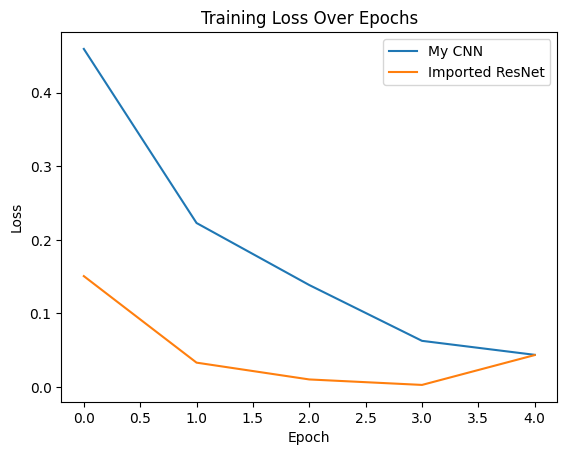

In [49]:
plt.plot(steps_1, values_1, label='My CNN')
plt.plot(steps_2, values_2, label='Imported ResNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

###

#### Check if my model work good

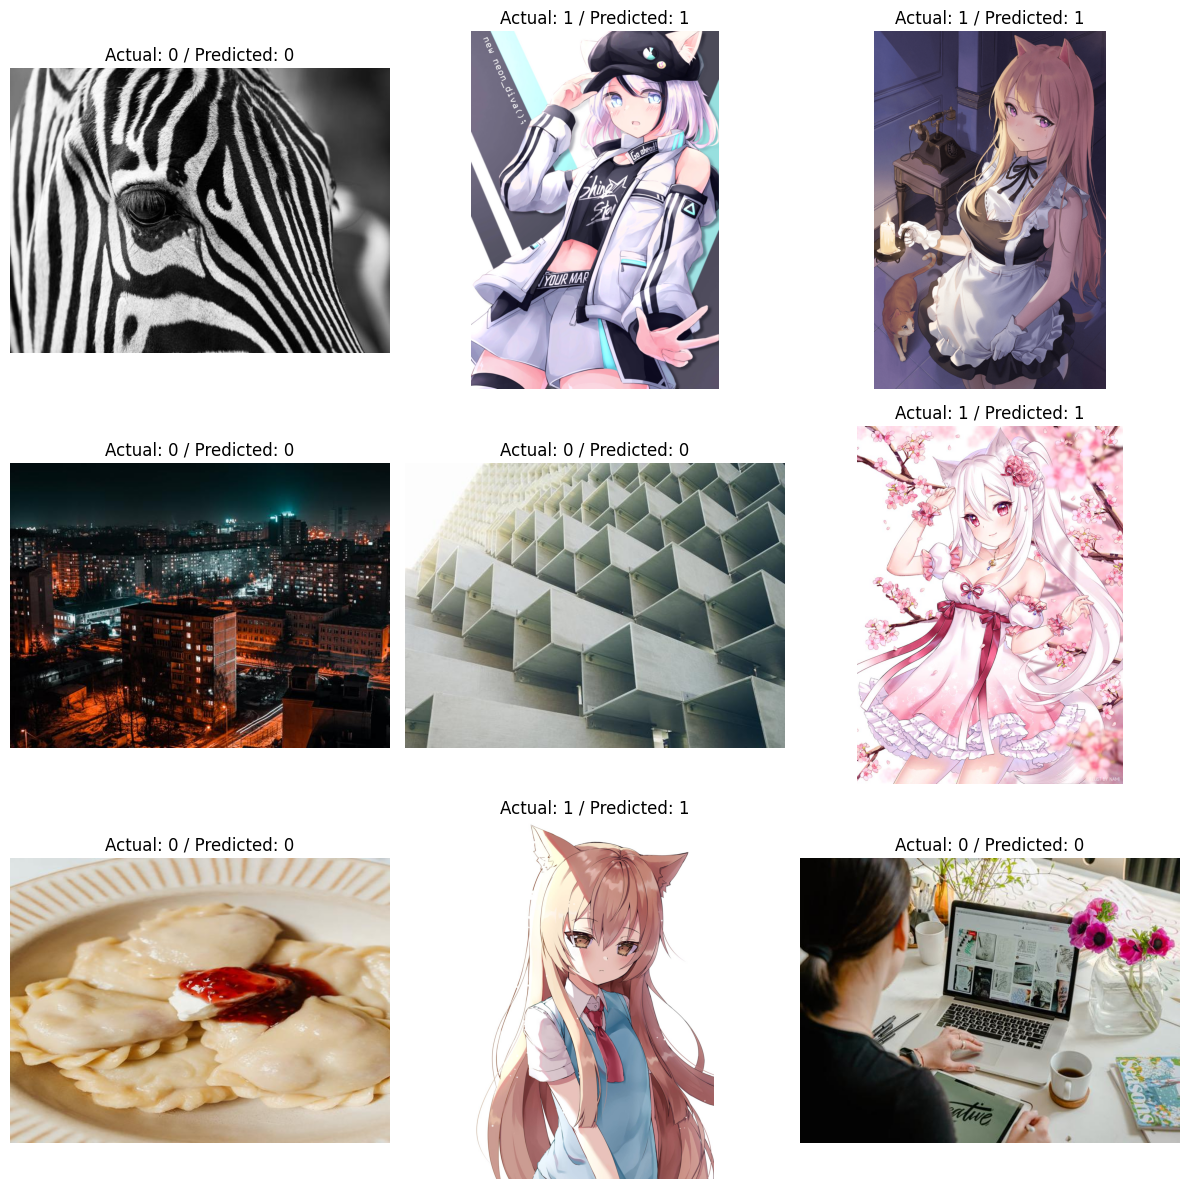

In [50]:
random_indices = random.sample(range(len(train_dataset)), 9)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(random_indices):
    img_path = train_dataset.data.iloc[idx, 0]
    label = train_dataset.data.iloc[idx, 1]
    image = Image.open(img_path).convert('RGB')

    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        predicted_label = int((output.squeeze() > 0.5).item())

    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f'Actual: {label} / Predicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()